# Neural Networks

---

## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical

import tensorflow as tf

%matplotlib inline

/Users/williammccarthy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Import and process data

In [3]:
#Importing the data from Kaggle
kag_train = pd.read_csv('/Users/williammccarthy/Downloads/digits/train.csv')
kag_test = pd.read_csv('/Users/williammccarthy/Downloads/digits/test.csv')

In [4]:
#Separating features and label
X = kag_train[kag_train.columns[1:]].values
y = kag_train['label']

#Scaling the features by a factor of 255 to put them between 0 and 1
#Turning 'label', which was 0-9, into categorical binary data
X = X/255
y = to_categorical(y)

#Scaling the test data
kag_test = kag_test/255

In [5]:
#Creating a train/test split for purposes of validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [6]:
kag_train.shape

(42000, 785)

In [7]:
kag_test.shape

(28000, 784)

## Keras Convolutional Network

In [26]:
#A convolutional network will want to take in a 2 dimensional input, so we will reshape
X_train_keras = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_keras = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [27]:
#Instantiate the sequential model
model = Sequential()

#Add a convolutional layer
model.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(28,28,1)))

#Add pooling layer
model.add(MaxPooling2D(pool_size=2))

#Add another convolutional layer
model.add(Conv2D(filters=8, kernel_size=3, activation='relu'))

#Add another pooling
model.add(MaxPooling2D(pool_size=2))

#Try some dropout (we can tune later)
model.add(Dropout(0.5))

#Flatten everything so we can get to dense. Maybe we can add more dense layers after
model.add(Flatten())

#But for now let's see how this works
model.add(Dense(10, activation='softmax'))

In [28]:
#Compile our model with the correct loss function for multiclass classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
#Gotta go somewhere for a couple hours, let's give this baby a run
#Couple hours, so I'm fine giving it 100 epochs
history = model.fit(X_train_keras, 
          y_train, 
          batch_size=32, 
          epochs=100, 
          verbose=1, 
          validation_data = (X_test_keras, y_test))

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 13s 422us/step - loss: 0.7146 - acc: 0.7681 - val_loss: 0.1977 - val_acc: 0.9429
Epoch 2/100
31500/31500 [==============================] - 13s 400us/step - loss: 0.3113 - acc: 0.9048 - val_loss: 0.1469 - val_acc: 0.9573
Epoch 3/100
31500/31500 [==============================] - 14s 429us/step - loss: 0.2530 - acc: 0.9214 - val_loss: 0.1289 - val_acc: 0.9620
Epoch 4/100
31500/31500 [==============================] - 14s 444us/step - loss: 0.2310 - acc: 0.9291 - val_loss: 0.1120 - val_acc: 0.9671
Epoch 5/100
31500/31500 [==============================] - 14s 439us/step - loss: 0.2179 - acc: 0.9322 - val_loss: 0.1049 - val_acc: 0.9691
Epoch 6/100
31500/31500 [==============================] - 13s 404us/step - loss: 0.2081 - acc: 0.9363 - val_loss: 0.0978 - val_acc: 0.9702
Epoch 7/100
31500/31500 [==============================] - 13s 400us/step - loss: 0.1963 - acc: 0.9412 - val_l

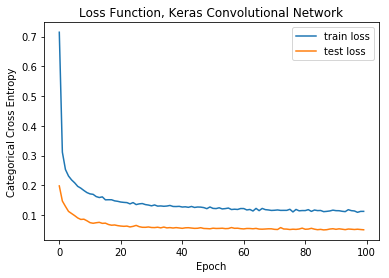

In [31]:
#Plot the losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Loss Function, Keras Convolutional Network')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epoch')
plt.legend();

In [58]:
#Reshape test set
kag_test = kag_test.values.reshape(kag_test.shape[0], 28, 28, 1)

#Predict our test values
preds_keras = model.predict_classes(kag_test)

In [113]:
#Put predictions into dataframe
keras_results = pd.DataFrame()
keras_results['Label'] = preds_keras
keras_results['ImageId'] = range(1,kag_test.shape[0] + 1)

In [114]:
#Export to csv
keras_results.to_csv('./keras_submission.csv')

## Tensorflow Network

In [8]:
#Build network
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, 
                   shape=(None,X_train.shape[1]),
                   name='X')
y = tf.placeholder(dtype=tf.float32,
                   shape=(None),
                   name='y')

hidden1 = tf.layers.dense(X, units=X_train.shape[1], 
                          name='hidden1',
                          activation=tf.nn.relu)
y_hat = tf.layers.dense(hidden1, 
                        units=y_train.shape[1],
                        activation=None)

loss = tf.losses.softmax_cross_entropy(y, y_hat)

optimizer = tf.train.AdamOptimizer(0.01)

training_op = optimizer.minimize(loss)

saver = tf.train.Saver()

In [9]:
#Run it!
init = tf.global_variables_initializer()

test_err = []
train_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(101):
        sess.run(training_op,
                 feed_dict={X:X_train, y:y_train})
        
        train_loss = sess.run(loss, feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        test_err.append(test_loss)
        train_err.append(train_loss)
        if epoch % 10 == 0:
            print('epoch', epoch+1, train_loss, test_loss)
            
    saver.save(sess, './tf_network.ckpt')
        
    pred = sess.run(y_hat, feed_dict={X:X_test})

epoch 1 1.208466 1.2014301
epoch 11 0.40215343 0.39240968
epoch 21 0.2405934 0.2458021
epoch 31 0.15115456 0.1682135
epoch 41 0.10405356 0.12929448
epoch 51 0.07133371 0.108259544
epoch 61 0.04901797 0.098536074
epoch 71 0.033609223 0.093673736
epoch 81 0.02307126 0.091367304
epoch 91 0.015960004 0.09050227
epoch 101 0.011207601 0.09060631


In [ ]:
plt.plot(test_err, label='test loss')
plt.plot(train_err, label='train loss')
plt.title('Loss Function, Tensorflow Network')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epoch')
plt.legend();

In [119]:
import numpy as np

In [121]:
len(pred)

10500

In [122]:
#Results into dataframe
tf_results = pd.DataFrame()
tf_results['Label'] = map(np.argmax, pred)
tf_results['ImageId'] = range(1,10501)

In [123]:
#Export to csv
tf_results.to_csv('./tf_submission.csv')